In [1]:
#pip install ptitprince
#pip install scanpy
#pip install leidenalg

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import os
import random
import pickle
from random import sample
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu
import itertools  
from statsmodels.stats.multitest import multipletests
from matplotlib.pyplot import rc_context
from adjustText import adjust_text
import matplotlib.collections as clt
import ptitprince as pt

### Clustering - iBAQ as input

In [3]:
# read in files
ibaq_norm=pd.read_csv('diann_prot_norm.csv', index_col=0)
auth_labels = pd.read_csv('diann_labels_author.csv', index_col=0)

In [4]:
# merge author labels and actin normalized ibaq quantities
auth_labels2=auth_labels.T.reindex(ibaq_norm.T.index)
df_merged = auth_labels2.merge(ibaq_norm.T,left_index=True, right_index=True)

In [5]:
# make AnnData object for clustering
dat = pd.read_csv('diann_prot_norm.csv', index_col=0)
dat['genes']=dat.index.str.replace("_HUMAN","")
dat=dat.set_index('genes')
ann_df = ad.AnnData(dat.T, dtype=float)

In [6]:
# remove pr in <5% of fibers (ie 3 fibers)
sc.pp.filter_genes(ann_df, min_cells=3)

In [7]:
# get mitochondrial DNA by cells
f = open('mt_list.txt','r')
mt_list = f.read().split(',')
for idx in range(len(mt_list)):
    mt_list[idx] = mt_list[idx].upper()
f.close()

In [8]:
ann_df.shape

(53, 738)

In [9]:
# Purity 
def cluster_purity(true_labels, pred_labels):
    max_num=0
    pred_df=pred_labels.to_frame()
    #print(pred_df)
    for x in pred_df['leiden'].unique():
        tmpdf=pred_df.loc[pred_df['leiden'] == x]
        #print(tmpdf)
        my_sub=true_labels.T.loc[tmpdf.index]
        max_num+=((my_sub['myosin'].value_counts()).max())
        purity=max_num/len(pred_df)
    return purity

In [10]:
# Entropy
def entropy(Y):
    unique, count = np.unique(Y, return_counts=True, axis=0)
    prob = count/len(Y)
    en = np.sum((-1)*prob*np.log2(prob))
    return en

#Joint Entropy
def jEntropy(Y,X):
    #H(Y;X)
    YX = np.c_[Y,X]
    return entropy(YX)

#Conditional Entropy
def cEntropy(Y, X):
    #conditional entropy = Joint Entropy - Entropy of X
    #H(Y|X) = H(Y;X) - H(X)
    return jEntropy(Y, X) - entropy(X)

#Information Gain
def gain(Y, X):
    #Information Gain, I(Y;X) = H(Y) - H(Y|X)
    return entropy(Y) - cEntropy(Y,X)

In [11]:
# define function that takes as inputs of whether to scale, # PCs, # neighbors, and leiden resolution and outputs cluster similarity metrics purity, conditional entropy and NMI
def get_clusters(file_name, SCALE, NUM_PCS, NUM_NEIGH, NUM_RES):
    # load data
    dat = pd.read_csv(file_name, index_col=0)
    dat['genes']=dat.index.str.replace("_HUMAN","")
    dat=dat.set_index('genes')
    ann_df = ad.AnnData(dat.T, dtype=float)
    # remove pr in <5% of fibers (ie 3 fibers)
    sc.pp.filter_genes(ann_df, min_cells=3)
    ann_df.var['mt'] = [c in mt_list for c in ann_df.var_names]
    sc.pp.calculate_qc_metrics(ann_df, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # scale to unit variance + clip values exceeding SD 10
    if SCALE:
        sc.pp.scale(ann_df, max_value=10)
    # reduce cols (variable proteins) to set of PCs that explain variance
    sc.tl.pca(ann_df,svd_solver='arpack')
    # UMAP and Leiden Clustering - reduce data to 2D and bin into discrete pop using Leiden
    sc.pp.neighbors(ann_df, n_pcs=NUM_PCS, n_neighbors=NUM_NEIGH) 
    sc.tl.umap(ann_df)
    sc.tl.leiden(ann_df, resolution=NUM_RES)
    # calculate metrics
    purity=cluster_purity(auth_labels,ann_df.obs['leiden'])
    cond_entropy_tp=cEntropy(pd.to_numeric(auth_labels.T['myosin'].reindex(ann_df.obs['leiden'].index).values),pd.to_numeric(ann_df.obs['leiden'].values))
    NMI=normalized_mutual_info_score(pd.to_numeric(auth_labels.T['myosin'].reindex(ann_df.obs['leiden'].index).values),pd.to_numeric(ann_df.obs['leiden'].values))
    return purity,cond_entropy_tp,NMI

In [12]:
# define function that takes in AnnData object and number of random iterations and outputs lists of params tried
def get_scores(ann_df, num_trials):
    n=0
    genes_list = []
    scale_list = []
    pc_list = []
    neigh_list = []
    res_list = []
    purity_list = []
    c_entropytp_list = []
    NMI_list = []
    #collect params
    while n<num_trials:
        random.seed(2+n)
        SCALE = random.choice([True, False])
        NUM_PCS = random.randrange(1,50)
        neigh_lst = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,30] 
        NUM_NEIGH = sample(neigh_lst,1)
        NUM_NEIGH = NUM_NEIGH[0]
        res_lst = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
        NUM_RES = sample(res_lst,1)
        NUM_RES = NUM_RES[0]
        purity,cond_entropy_tp,NMI = get_clusters(ann_df, SCALE, NUM_PCS,NUM_NEIGH,NUM_RES)
        scale_list.append(SCALE)
        pc_list.append(NUM_PCS)
        neigh_list.append(NUM_NEIGH)
        purity_list.append(purity)
        c_entropytp_list.append(cond_entropy_tp)
        NMI_list.append(NMI)
        res_list.append(NUM_RES)
        n+=1  
    return scale_list,pc_list,neigh_list,res_list,purity_list, c_entropytp_list, NMI_list

In [14]:
#random search of 300 iterations of above params
scale_list,pc_list,neigh_list,res_list,purity_list,c_entropy_tplist, NMI_list=get_scores('diann_prot_norm.csv',300)

In [ ]:
finaldf = pd.DataFrame({'SCALE':scale_list,'NUM_PCS':pc_list,'NUM_NEIGH':neigh_list,
                        'NUM_RES':res_list,'PURITY':purity_list, 
                        'COND_ENTROPY(TRUE,PRED)':c_entropy_tplist, 'NMI':NMI_list})

In [ ]:
# find params corresponding to optimal NMI 
finaldf[finaldf.NMI==finaldf.NMI.max()]

In [15]:
palette_set2 = sns.color_palette("Set2")

In [16]:
palette = sns.color_palette([palette_set2[0], palette_set2[1]])

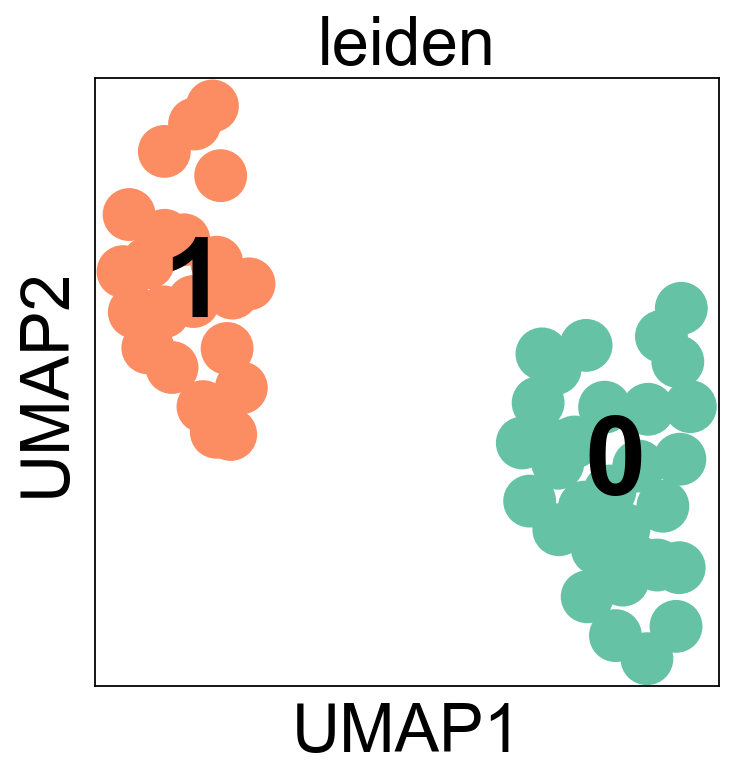

In [17]:
# Use params with highest NMI = 33 PCSs, 11 n_neighbors, 0.1 resolution
dat = pd.read_csv('diann_prot_norm.csv', index_col=0)
dat['genes']=dat.index.str.replace("_HUMAN","")
dat=dat.set_index('genes')
ann_df = ad.AnnData(dat.T, dtype=float)
# Remove pr in <5% of fibers (ie 3 fibers)
sc.pp.filter_genes(ann_df, min_cells=3)
ann_df.var['mt'] = [c in mt_list for c in ann_df.var_names]
sc.pp.calculate_qc_metrics(ann_df, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# reduce cols to set of PCs 
sc.tl.pca(ann_df,svd_solver='arpack')
# UMAP and Leiden Clustering
sc.pp.neighbors(ann_df, n_pcs=33, n_neighbors=11) 
sc.tl.umap(ann_df)
sc.tl.leiden(ann_df, resolution=0.1)
sc.set_figure_params(fontsize=30)
with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['leiden'],legend_fontsize=50, add_outline=False, outline_width=(0.2, 0.3),legend_fontweight='bold', legend_loc='on data',palette=palette,save='4A.svg')
plt.show()

In [18]:
#calculate metrics
purity=cluster_purity(auth_labels,ann_df.obs['leiden'])
print('purity:',purity)
cond_entropy_tp=cEntropy(pd.to_numeric(auth_labels.T['myosin'].reindex(ann_df.obs['leiden'].index).values),pd.to_numeric(ann_df.obs['leiden'].values))
print('CE true,pred:',cond_entropy_tp)
NMI=normalized_mutual_info_score(pd.to_numeric(auth_labels.T['myosin'].reindex(ann_df.obs['leiden'].index).values),pd.to_numeric(ann_df.obs['leiden'].values))
print('NMI',NMI)

purity: 0.8301886792452831
CE true,pred: 0.7248584629128987
NMI 0.6967569627432483


In [19]:
# plot same UMAP as above but colored by author myosin annotations
df_merged[['myosin']]=df_merged[['myosin']].replace('0','MYH7')
df_merged[['myosin']]=df_merged[['myosin']].replace('1','MYH2/7')
df_merged[['myosin']]=df_merged[['myosin']].replace('2','MYH2')
df_merged[['myosin']]=df_merged[['myosin']].replace('3','MYH1/2')

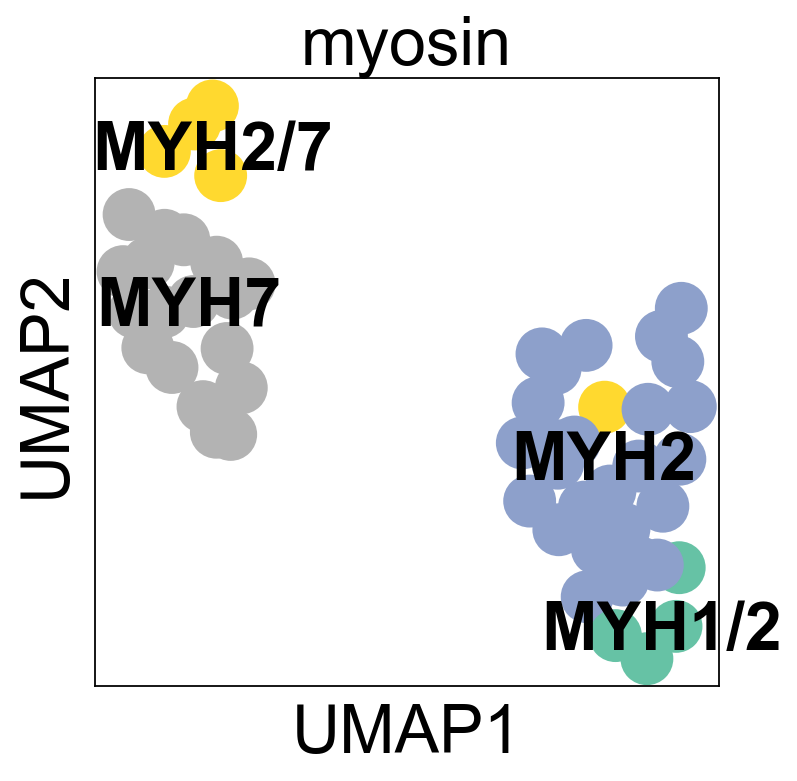

In [20]:
dat = pd.read_csv('diann_prot_norm.csv', index_col=0)
dat['genes']=dat.index.str.replace("_HUMAN","")
dat=dat.set_index('genes')
ann_df = ad.AnnData(dat.T, dtype=float)
#Remove pr in <5% of fibers (ie 3 fibers)
sc.pp.filter_genes(ann_df, min_cells=3)
ann_df.var['mt'] = [c in mt_list for c in ann_df.var_names]
sc.pp.calculate_qc_metrics(ann_df, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#reduce cols to set of PCs 
sc.tl.pca(ann_df,svd_solver='arpack')
#UMAP and Leiden Clustering 
sc.pp.neighbors(ann_df, n_pcs=33, n_neighbors=11) 
sc.tl.umap(ann_df)
sc.tl.leiden(ann_df, resolution=0.1)
ann_df.obs['myosin'] = df_merged['myosin']
with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['myosin'],legend_fontsize=30, add_outline=False, legend_loc='on data', palette='Set2',save='4B.svg')
plt.show()

In [21]:
palette_tab = sns.color_palette("tab10")

In [22]:
palette = sns.color_palette([palette_tab[3], palette_tab[9]])

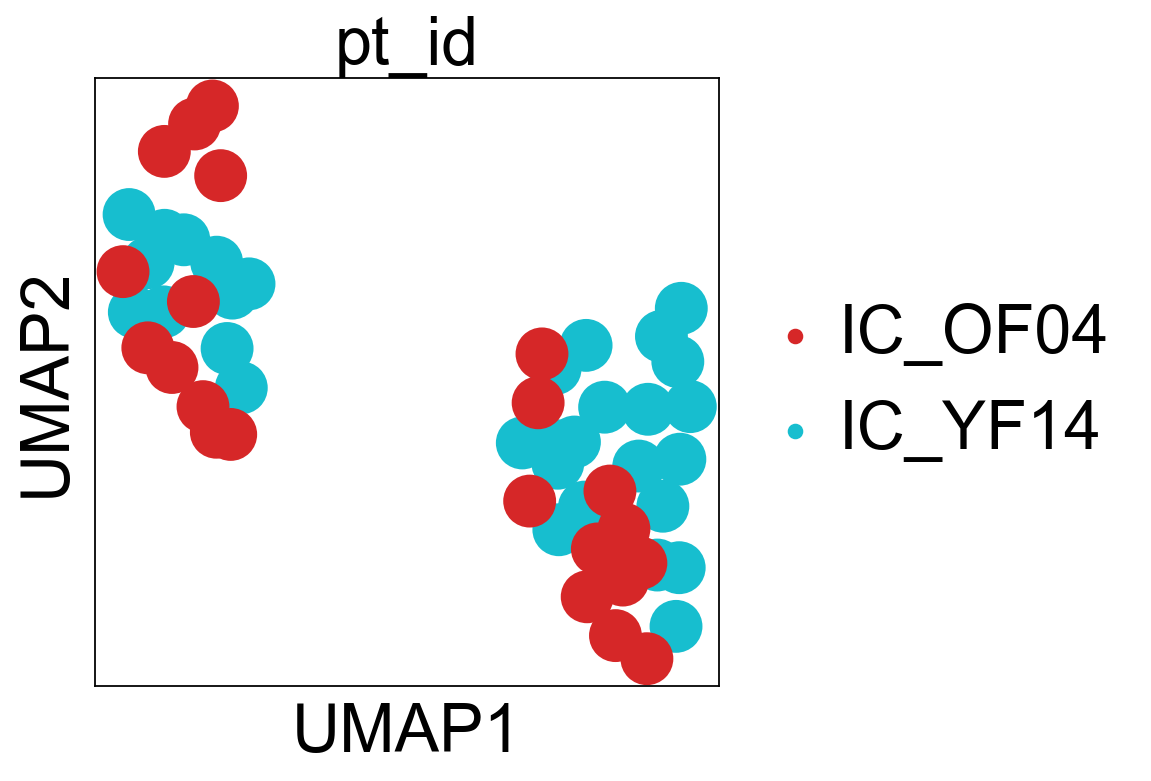

In [23]:
# plot same UMAP as above but colored by young vs old
dat = pd.read_csv('diann_prot_norm.csv', index_col=0)
dat['genes']=dat.index.str.replace("_HUMAN","")
dat=dat.set_index('genes')
ann_df = ad.AnnData(dat.T, dtype=float)
# remove pr in <5% of fibers (ie 3 fibers)
sc.pp.filter_genes(ann_df, min_cells=3)
ann_df.var['mt'] = [c in mt_list for c in ann_df.var_names]
sc.pp.calculate_qc_metrics(ann_df, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
#reduce cols to set of PCs 
sc.tl.pca(ann_df,svd_solver='arpack')
# UMAP and Leiden clustering 
sc.pp.neighbors(ann_df, n_pcs=33, n_neighbors=11) 
sc.tl.umap(ann_df)
sc.tl.leiden(ann_df, resolution=0.1)
ann_df.obs['pt_id'] = df_merged['pt_id']
with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['pt_id'],legend_fontsize=30, add_outline=False,  palette=palette,save='SF5.svg')
plt.show()

In [24]:
df=ann_df.obs[['leiden','pt_id']]

In [25]:
df[df.leiden=='0'].pt_id.value_counts()

IC_YF14    20
IC_OF04    11
Name: pt_id, dtype: int64

In [26]:
# defining the table
data = [11,20], [11,11]
stat, p, dof, expected = chi2_contingency(data)
  
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.4389828475241444
Independent (H0 holds true)


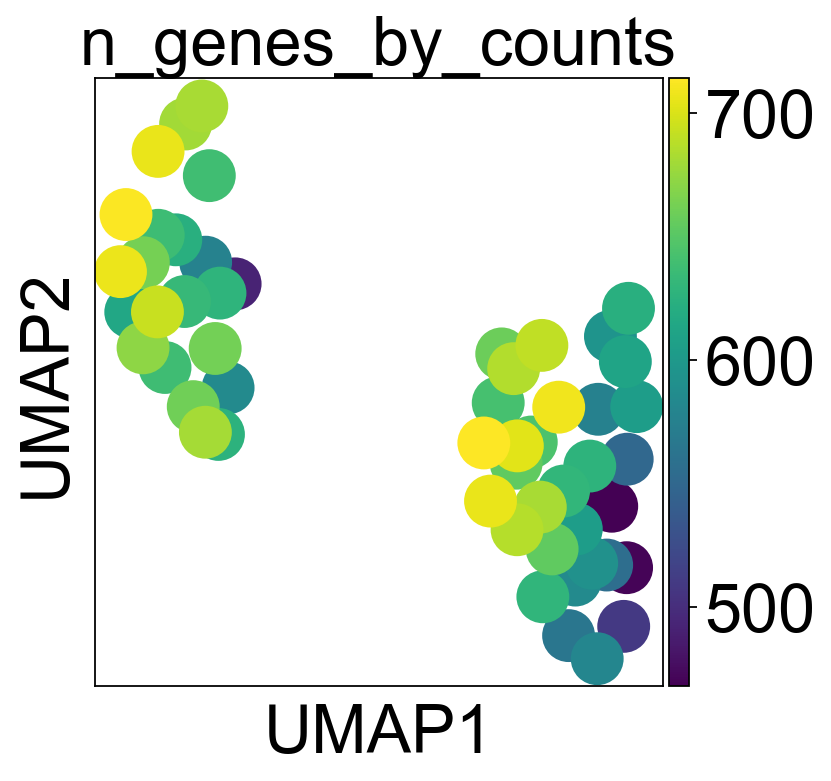

In [27]:
sc.set_figure_params(fontsize=30)

with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['n_genes_by_counts'],legend_fontsize=10, add_outline=False, outline_width=(0.2, 0.3),legend_fontweight='bold', legend_loc='on data',palette='icefire',save='4C.svg')
plt.show()

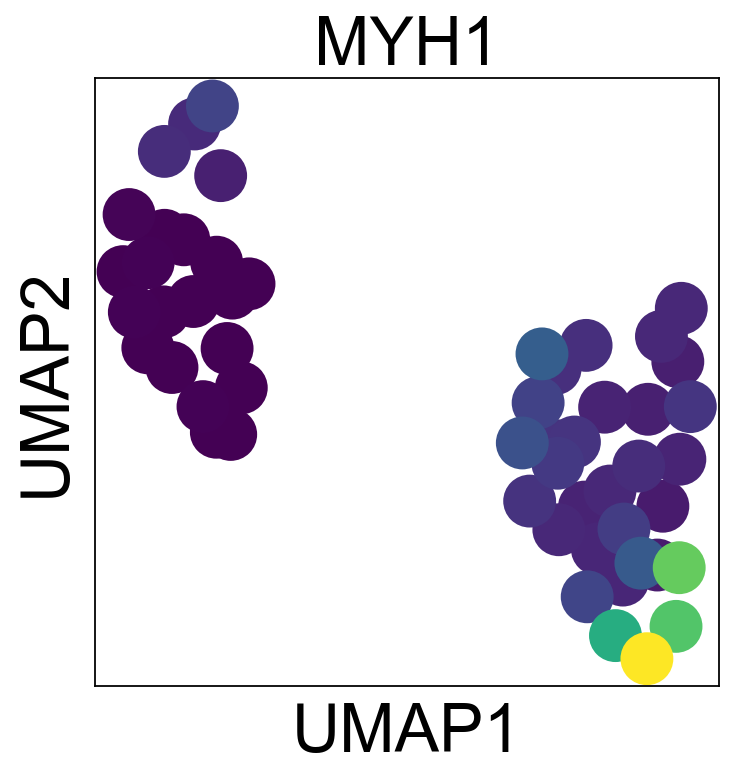

In [28]:
sc.set_figure_params(fontsize=30)

with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['MYH1'],colorbar_loc=None,legend_fontsize=50, add_outline=False, outline_width=(0.2, 0.3),legend_fontweight='bold', legend_loc='on data',palette='icefire',save='4D1.svg')
plt.show()

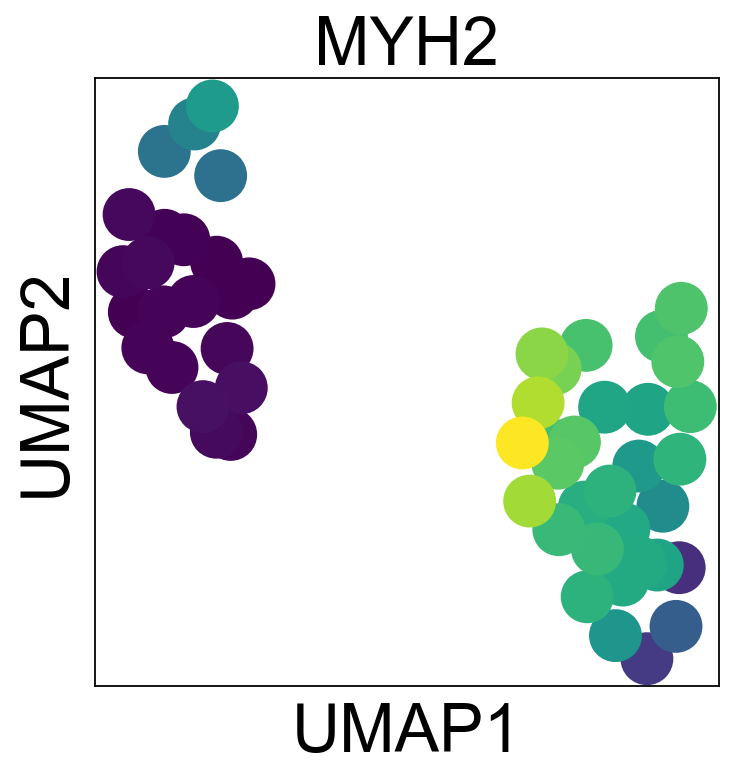

In [29]:
sc.set_figure_params(fontsize=30)

with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['MYH2'],colorbar_loc=None,legend_fontsize=50, add_outline=False, outline_width=(0.2, 0.3),legend_fontweight='bold', legend_loc='on data',palette='icefire',save='4D2.svg')
plt.show()

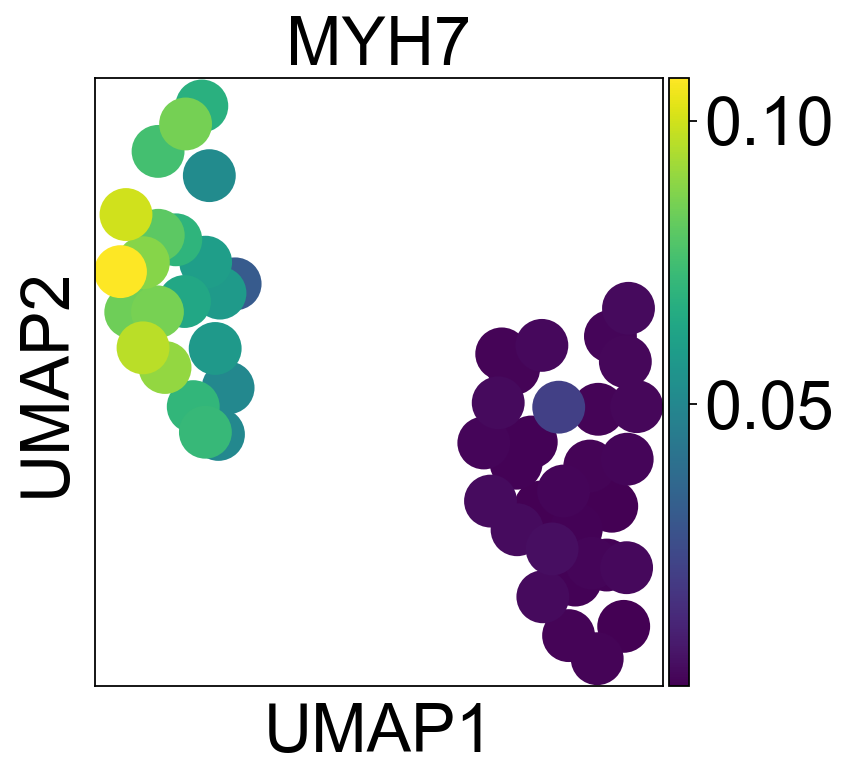

In [30]:
sc.set_figure_params(fontsize=30)

with plt.rc_context({"figure.figsize": (5,5)}):
    sc.pl.umap(ann_df,  color=['MYH7'],legend_fontsize=50, add_outline=False, outline_width=(0.2, 0.3),legend_fontweight='bold', legend_loc='on data',palette='icefire',save='3D3.svg')
plt.show()

## Finding differentially expressed proteins between leiden 0 v 1

In [31]:
ibaq_norm=pd.read_csv('diann_prot_norm.csv', index_col=0)

In [32]:
prot_leid=ibaq_norm.T.merge(ann_df.obs['leiden'], left_index=True, right_index=True)

In [33]:
leid0=prot_leid.loc[prot_leid['leiden'] == '0']

In [34]:
leid1=prot_leid.loc[prot_leid['leiden'] == '1']

In [35]:
leid0_d=leid0.drop(['leiden'],axis=1)

In [36]:
leid1_d=leid1.drop(['leiden'],axis=1)

In [37]:
prot_leid_d=prot_leid.drop(['leiden'],axis=1)

In [38]:
prot_leid_d=prot_leid_d.T

In [39]:
prot_leid_d['mean0'] = leid0_d.mean().tolist()

In [40]:
prot_leid_d['mean1'] = leid1_d.mean().tolist()

In [41]:
prot_leid_d=prot_leid_d.reset_index()

In [42]:
prot_leid_d_vol=prot_leid_d[['index','mean0','mean1']]

In [43]:
prot_leid_d_vol['log_fc']=np.log2(prot_leid_d_vol['mean0']) - np.log2(prot_leid_d_vol['mean1'])

C:\Users\momenzadeha\Anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_18116\3300225469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_leid_d_vol['log_fc']=np.log2(prot_leid_d_vol['mean0']) - np.log2(prot_leid_d_vol['mean1'])


In [44]:
prot_leid_d_vol['index']=prot_leid_d_vol['index'].str.replace("_HUMAN","")

C:\Users\momenzadeha\AppData\Local\Temp\ipykernel_18116\1508984202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_leid_d_vol['index']=prot_leid_d_vol['index'].str.replace("_HUMAN","")


In [45]:
prot_leid_d_vol=prot_leid_d_vol.set_index(['index'])

In [46]:
prot_all_melt = pd.melt(prot_leid, id_vars=['leiden'], value_vars=ibaq_norm.T.columns.tolist())
prot_all_melt.shape

(39432, 3)

In [47]:
prot_all_melt=prot_all_melt.rename(columns={"variable": "Proteins"})

In [48]:
prot_all_melt['leiden'] = prot_all_melt['leiden'].astype('int')

In [49]:
# calculate p values for each protein between leiden 0 and 1 using mann whitney u test
pvalues=[]
i=0
for x in prot_all_melt['Proteins'].unique():
    tempdf = prot_all_melt[prot_all_melt.isin([x]).any(axis=1)]
    coh0=[]
    coh1=[]
    coh0.append(tempdf[(tempdf.leiden==0)]['value'].tolist())
    coh1.append(tempdf[(tempdf.leiden==1)]['value'].tolist())
    ab = itertools.chain(coh0, coh1)
    data=list(ab)
    t_val, p_val = mannwhitneyu(*data)
    pvalues.append(p_val)
    i+=1
    if i % 100==0: 
        print(i)

100
200
300
400
500
600
700


#### Benjamini-Hochberg multiple testing correction

In [50]:
y=multipletests(pvals=pvalues, method="fdr_bh")

In [51]:
len(y[1])

744

In [52]:
#find how many pvalues are < 0.01
print(len(y[1][np.where(y[1]<0.01)])) 

94


In [53]:
y_array=y[1][np.where(y[1]<0.01)]

In [54]:
y_list=y_array.tolist()

In [55]:
T=np.where(y[1] <0.01)

In [56]:
prot_leid_d_vol['neg_log_pval']=np.log10(y[1]) * (-1)

In [57]:
prot_leid_d_vol['adj.P.Val']=y[1]

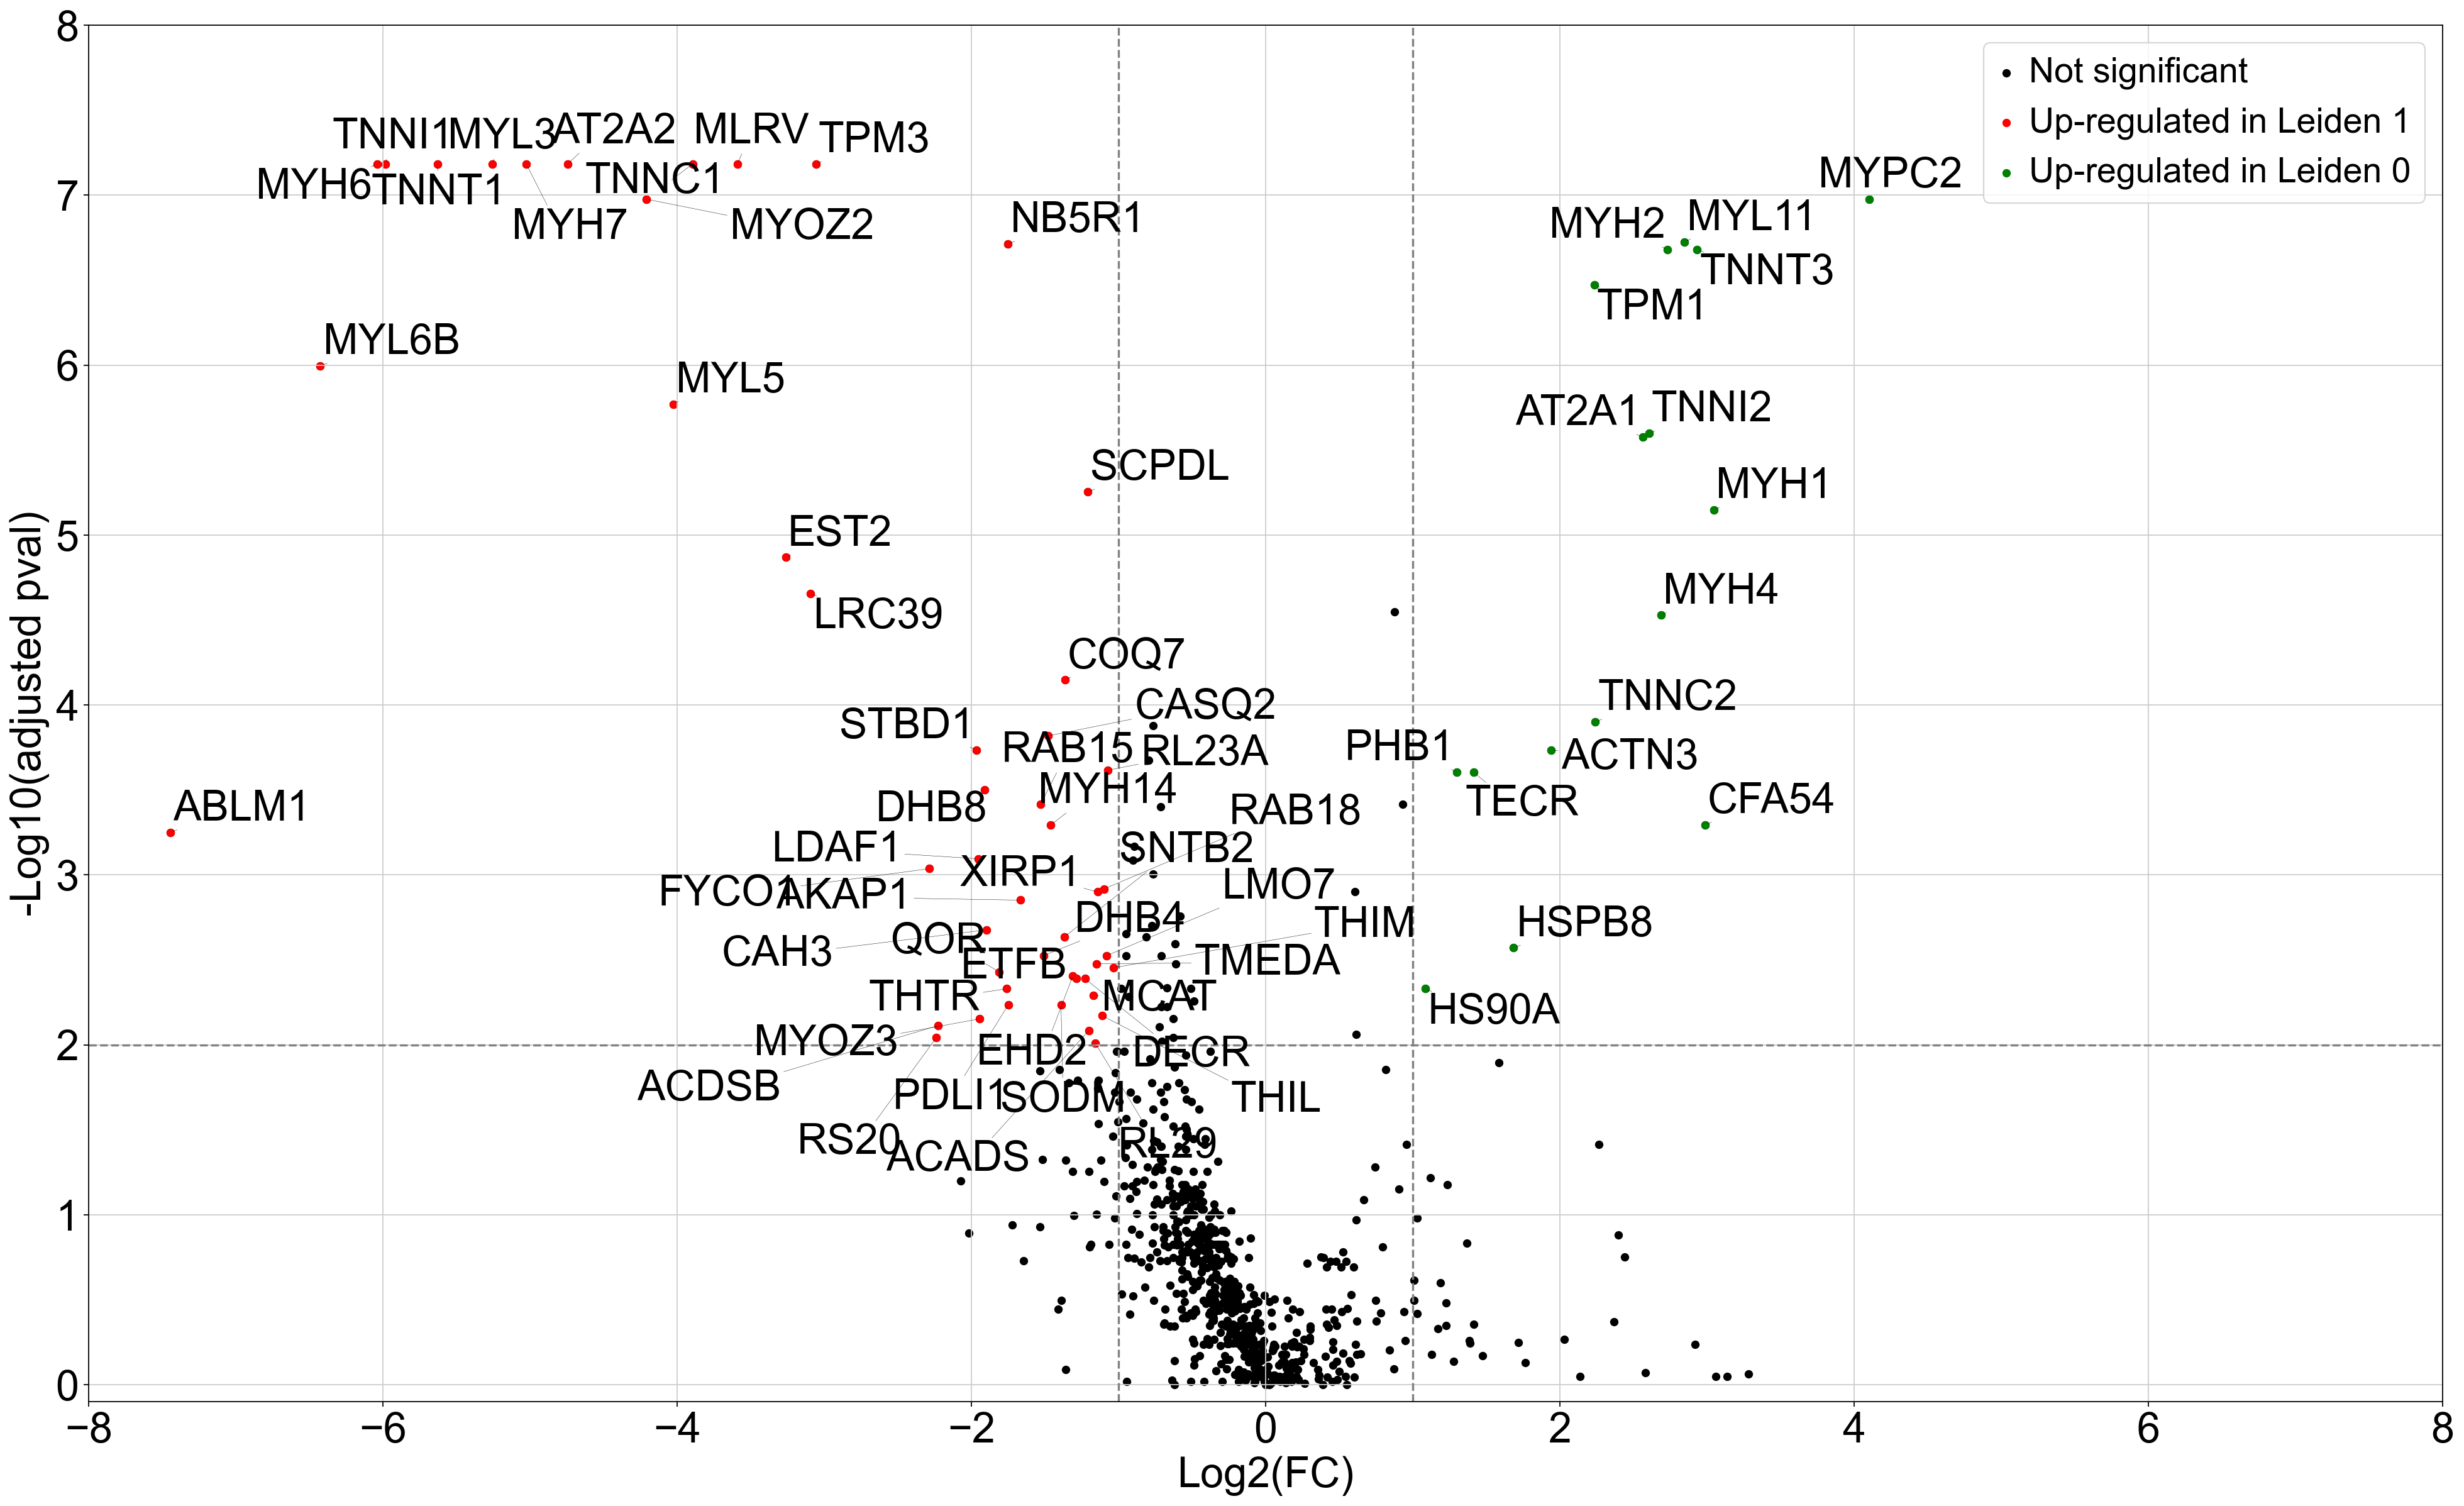

In [58]:
plt.figure(figsize=(30,18))

plt.scatter(x=prot_leid_d_vol['log_fc'], y=prot_leid_d_vol['adj.P.Val'].apply(lambda x:-np.log10(x)), s=25,label="Not significant", color='black')

down = prot_leid_d_vol[(prot_leid_d_vol['log_fc']<=-1)&(prot_leid_d_vol['adj.P.Val']<=0.01)]
up = prot_leid_d_vol[(prot_leid_d_vol['log_fc']>=1)&(prot_leid_d_vol['adj.P.Val']<=0.01)]

plt.scatter(x=down['log_fc'],y=down['adj.P.Val'].apply(lambda x:-np.log10(x)),s=25,label="Up-regulated in Leiden 1",color="red")
plt.scatter(x=up['log_fc'],y=up['adj.P.Val'].apply(lambda x:-np.log10(x)),s=25,label="Up-regulated in Leiden 0",color="green")
texts=[]
for i,r in up.iterrows():
    texts.append(plt.text(x=r['log_fc'],y=-np.log10(r['adj.P.Val']),s=i))
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.2))
texts2=[]
for i,r in down.iterrows():
    texts2.append(plt.text(x=r['log_fc'],y=-np.log10(r['adj.P.Val']),s=i))
adjust_text(texts2,arrowprops=dict(arrowstyle="-", color='black', lw=0.2))
plt.xlabel("logFC")
plt.ylabel("-logFDR")
plt.axvline(-1,color="grey",linestyle="--")
plt.axvline(1,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.xlim(-8,8)
plt.ylim(-0.1,8)
plt.legend(fontsize=25)
plt.ylabel("-Log10(adjusted pval)", fontsize=30)
plt.xlabel("Log2(FC)", fontsize=30)
plt.xticks(
    fontweight='light',
    fontsize=30  
)
plt.yticks(
    fontweight='light',
    fontsize=30
)
plt.savefig('plots/SF4.svg', bbox_inches='tight')

In [59]:
sig_prot=prot_leid_d_vol[(abs(prot_leid_d_vol['log_fc'])>=1) & (prot_leid_d_vol['neg_log_pval']>2)].sort_values(by='log_fc',ascending=False)

In [60]:
log_ibaq_norm=np.log2(ibaq_norm+1)

In [61]:
FA_ox=log_ibaq_norm.T[['DECR_HUMAN','THIL_HUMAN','ETFB_HUMAN','ACADS_HUMAN','MCAT_HUMAN']]

In [62]:
FA_ox_leid=FA_ox.merge(ann_df.obs['leiden'],left_index=True, right_index=True)

In [63]:
FA_ox_leid_melt=FA_ox_leid.melt(id_vars=['leiden'])

In [64]:
FA_ox_leid_melt.rename(columns = {'variable':'Protein','value':'Log2(iBAQ+1)'}, inplace = True)

In [65]:
ort="h"; pal = sns.color_palette(n_colors=1)

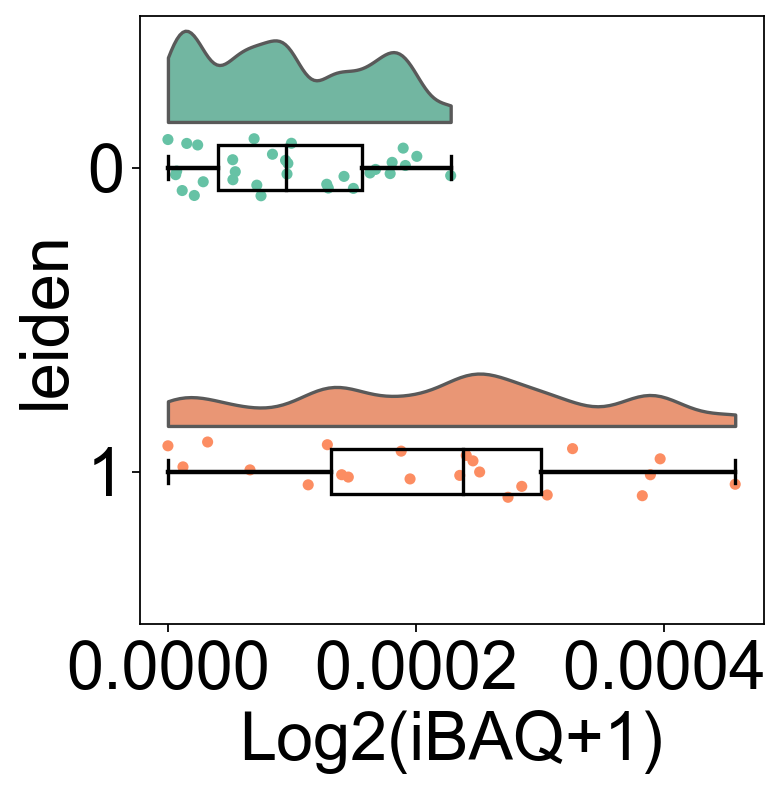

In [66]:
# MCAT
pal = "Set2"
f, ax = plt.subplots(figsize=(5,5))
ax=pt.half_violinplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='MCAT_HUMAN'], palette = pal, bw = .2, cut = 0.,
scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='MCAT_HUMAN'], palette = pal, edgecolor = "white",
size = 5, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='MCAT_HUMAN'],  color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)
ax.grid(False)
plt.savefig('plots/5B_mcat.svg', bbox_inches='tight')

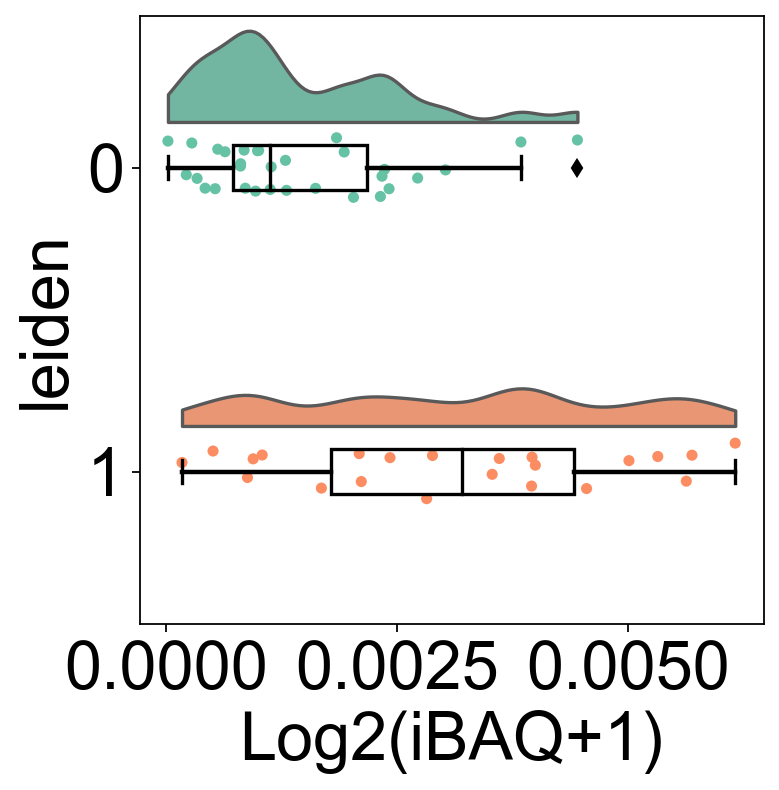

In [67]:
# ACAT1
pal = "Set2"
f, ax = plt.subplots(figsize=(5,5))
ax=pt.half_violinplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='THIL_HUMAN'], palette = pal, bw = .2, cut = 0.,
scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='THIL_HUMAN'], palette = pal, edgecolor = "white",
size = 5, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='THIL_HUMAN'],  color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)
ax.grid(False)
plt.savefig('plots/5B_acat1.svg', bbox_inches='tight')

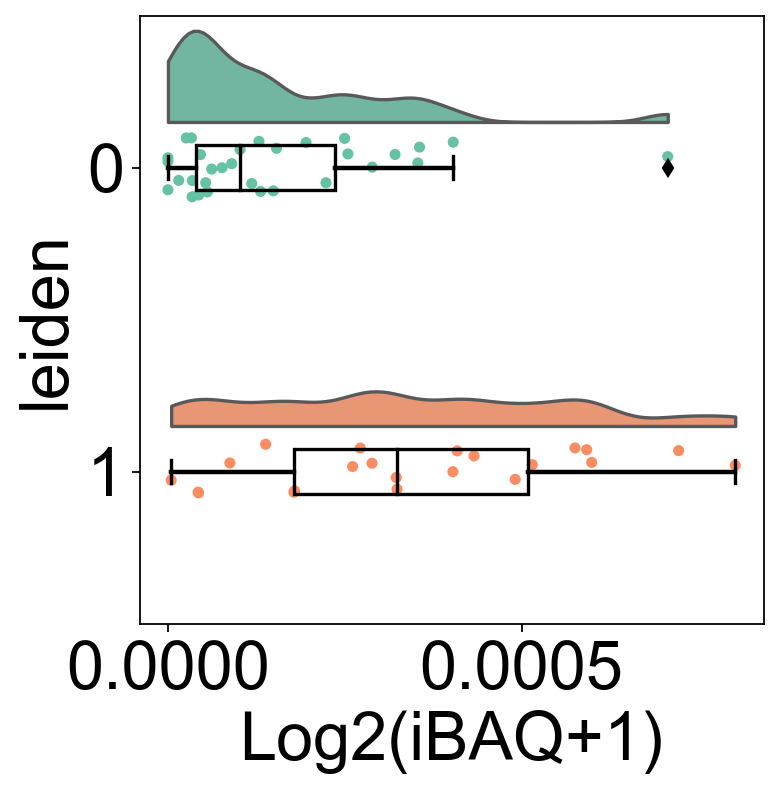

In [68]:
# ACADS 
pal = "Set2"
f, ax = plt.subplots(figsize=(5,5))
ax=pt.half_violinplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='ACADS_HUMAN'], palette = pal, bw = .2, cut = 0.,
scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='ACADS_HUMAN'], palette = pal, edgecolor = "white",
size = 5, jitter = 1, zorder = 0, orient = ort)
ax=sns.boxplot( y = 'leiden', x = "Log2(iBAQ+1)", data = FA_ox_leid_melt[FA_ox_leid_melt['Protein']=='ACADS_HUMAN'],  color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)
ax.grid(False)
plt.savefig('plots/5B_acads.svg', bbox_inches='tight')